# CAM-PyTorch

We will implement CAM by PyTorch.

### Import Labraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

import torch
import torch.nn.functional as F

from pretrainedmodels import inceptionv3
from utils import load_image, preprocess_image, load_class_idx

%matplotlib inline

### Load Inception V3

Before using CAM we need to check that the model has to have a global average pooling layer following a fully-connected layer as its output layer. Not all model satisfies the specific configuration, so we need to modify our model and re-train it before using CAM.

Luckly, there is already a model called Inception v3 that exactly has a global average pooling layer and a fully-connected layer at its tail. So we can directly use Inception v3 for demonstration without modification and re-training.

![](inceptionv3.png)

In [2]:
model = inceptionv3(num_classes=1000, pretrained='imagenet').eval()

In [3]:
print(model)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

From
[here](https://github.com/Cadene/pretrained-models.pytorch/blob/master/pretrainedmodels/models/torchvision_models.py#L265)
we can see that the inception v3 model supplied by `pretrainedmodels` is separated into two parts, one is `features` and the other is `logits`.

All convolutional operations are done by the function `features`, and pass the intermediate result through the global average pooling and the fully-connected layer in `logits` to output the final logits.

Therefore, we can use the features generated by `features` and the probability generated by `logits`.

### Implement CAM

![](cam.png)

In [4]:
class CAM:
    def __init__(self, model):
        self.model = model
        self.probas = None
        self.features = None
        self.size = model.input_size[1:]
        self.idx2label = load_class_idx()
        
        self.model.eval()
        
        weight, bias = list(self.model.last_linear.parameters())
        self.weight = weight.detach().numpy()  # (1000, 2048)
        
        del weight, bias
    
    def _forward(self, img):
        with torch.no_grad():
            features = self.model.features(img)  # (1, c, h, w)
            logits = self.model.logits(features)  # (1, n_classes)
            probas = F.softmax(logits, dim=-1)
            
        self.features = features.numpy().squeeze()  # (c, h, w)
        self.probas = probas.numpy().squeeze()  # (n_classes)
    
    def _get_class_idx(self, i):
        class_idx = self.probas.argsort()
        class_idx = class_idx[-i]
        
        return class_idx
    
    def _generate_heatmap(self, class_idx):
        weight_c = self.weight[class_idx, :]  # (c,)
        weight_c = weight_c.reshape((-1, 1, 1))  # (c, 1, 1)

        heatmap = np.sum(weight_c * self.features, axis=0)  # (h, w)
        heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))  # Normalize between 0-1
        heatmap = np.uint8(heatmap * 255)
        heatmap = Image.fromarray(heatmap)
        heatmap = heatmap.resize(self.size, Image.ANTIALIAS)
        heatmap = np.array(heatmap)
        
        return heatmap
    
    def plot_image_heatmap(self, img, top=1):
        img_tensor = preprocess_image(img, self.model.mean, self.model.std)  # (1, 3, 299, 299)
        
        self._forward(img_tensor)
        
        cols = top + 1
        plt.figure(figsize=(4 * cols, 4))
        
        for i in range(cols):
            if i == 0:
                plt.subplot(1, cols, i+1)
                plt.imshow(img, alpha=1.0)
                plt.title('Original image')
                plt.axis('off')
            else:
                class_idx = self._get_class_idx(i)
                label = self.idx2label[class_idx]
                proba = self.probas[class_idx]
                heatmap = self._generate_heatmap(class_idx)
                
                plt.subplot(1, cols, i+1)
                plt.imshow(img, alpha=1.0)
                plt.imshow(heatmap, cmap='jet', alpha=0.5)
                plt.title('{} ({:.3f})'.format(label, proba))
                plt.axis('off')

### Results

In [5]:
cam = CAM(model=model)

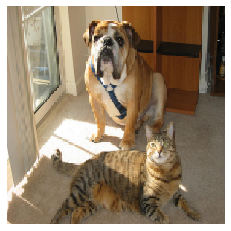

In [6]:
img = load_image('../images/cat_dog.png')

plt.imshow(img, alpha=1.0)
plt.axis('off');

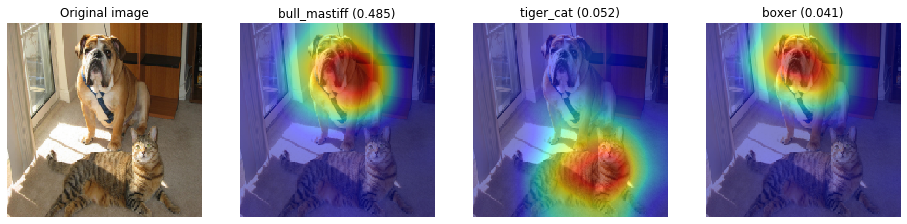

In [7]:
cam.plot_image_heatmap(img, top=3)

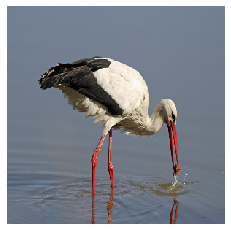

In [8]:
img = load_image('../images/white stork.jpg')

plt.imshow(img, alpha=1.0)
plt.axis('off');

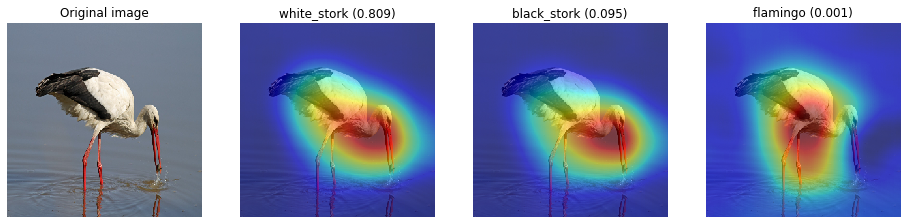

In [9]:
cam.plot_image_heatmap(img, top=3)

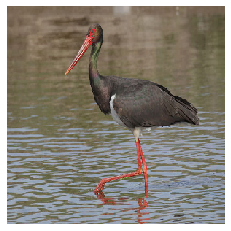

In [10]:
img = load_image('../images/black stork.jpg')

plt.imshow(img, alpha=1.0)
plt.axis('off');

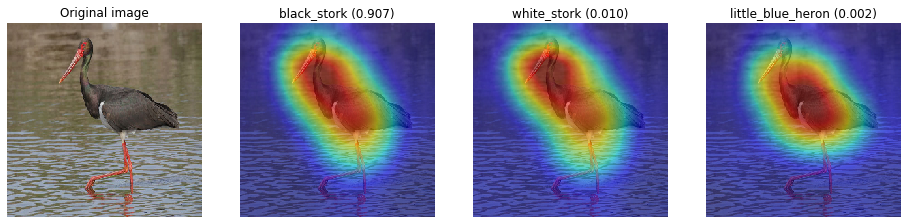

In [11]:
cam.plot_image_heatmap(img, top=3)

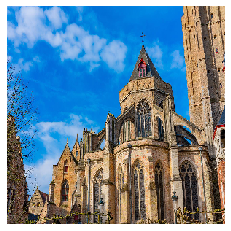

In [12]:
img = load_image('../images/church.jpg')

plt.imshow(img, alpha=1.0)
plt.axis('off');

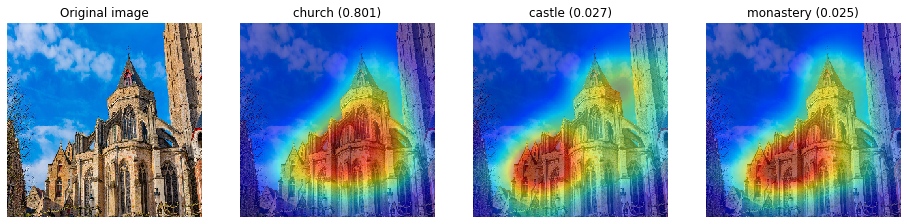

In [13]:
cam.plot_image_heatmap(img, top=3)

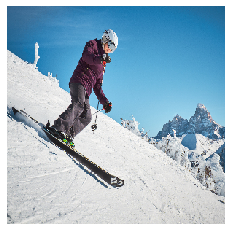

In [14]:
img = load_image('../images/ski.jpg')

plt.imshow(img, alpha=1.0)
plt.axis('off');

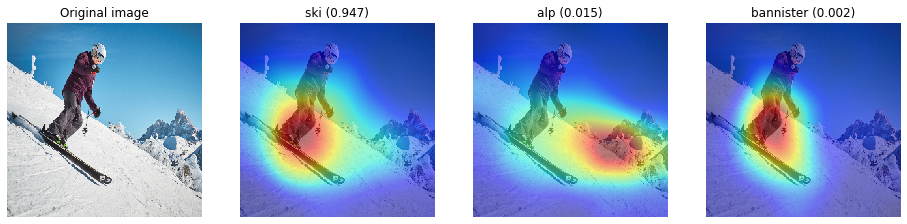

In [15]:
cam.plot_image_heatmap(img, top=3)